In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

In [2]:
#this method returns:
#X_train: a list of tuples from the dataset. Each index groups X values based on kmeans++ predictions
#y_train: the corresponding target for each value in X_train

def kmeans_test_split(X,y, n_clusters):

    kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10)
    y_kmeans = kmeans.fit_predict(X) 
    
    X_train=[]
    y_train=[]
    
    for i in range(n_clusters):
        X_train.append(X[y_kmeans == i, :])
        y_train.append(y[y_kmeans==i])
    
    return X_train,y_train


def kmeans_get_optimal_cluster_number(X,y):
    #Finding the optimum number of clusters for k-means classification
    wcss = []

    for i in range(1, 11):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)


    #Plotting the results onto a line graph, allowing us to observe 'The elbow'
    plt.plot(range(1, 11), wcss)
    plt.title('The elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS') #within cluster sum of squares
    plt.show()
    
    return 3

    #The optimum number of clusters is found where the within cluster sum of squares (inertia)
    #won't decrease significantly on any next iteration. By looking at the plot, 3 seems the
    #ideal number of clusters but I still need to find a mathematical way to implement this decision
    #Temporarily hardcoded return value

In [3]:
import numpy as np
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.cluster import KMeans

class CustomEstimator(BaseEstimator):
    
    def __init__(self, n_estimators, similarity_function, base_model):
        self.n_estimators = n_estimators #it's the number of classifiers trained on each test set
        self.similarity_function = similarity_function
        self.base_model = base_model
        
    
    def fit(self,X,y):
        
        #Getting a list of different test sets, temporarily using only kmeans_test_split() but of course
        #it will be based on the similarity_function value. Also, kmeans_test_split will need to use the elbow method
        #to detect the optimal number of clusters
        n_clusters = kmeans_get_optimal_cluster_number(X,y)
        X_train, y_train = kmeans_test_split(X,y,n_clusters)
        
        
        #support lists to compose the estimator list that can be accepted by the voting clf
        est_clf = [] 
        est_names = []
                
        for i in range(n_clusters):
            for j in range(self.n_estimators):
                X_selected = X_train[i]
                y_selected = y_train[i]
                #it is possible to expand this by creating another list of different classifiers and iterate said list
                est_clf.append(DecisionTreeClassifier(max_depth=2).fit(X_selected, y_selected))
                est_names.append(("model % s" % i+".% s"%j))
        
        #final list fed to the voting classifier
        estimators = list(zip(est_names,est_clf))
            
        
        voting_clf = VotingClassifier(estimators = estimators, voting='soft')
        self.value_ = voting_clf.fit(X,y)
        
        return self
            
    
    def predict(self, X):
        out = self.value_.predict(X)
        return out
    
    def predict_proba(self, X):
        out = self.value_.predict_proba(X)
        return out

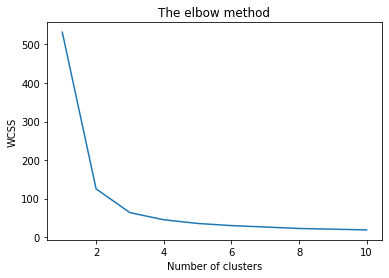

prediction: [0 1 2 0 2 1 2 0 1 0 2 0 1 1 0 2 0 0 2 0 1 0 1 1 0 2 1 2 0 1] 
    values: [0 1 2 0 2 1 2 0 1 0 2 0 1 1 0 1 0 0 2 0 2 0 2 1 0 2 1 2 0 1]
prediction probabilities:
      0     |     1     |     2
 [[1.         0.         0.        ]
 [0.         0.93181818 0.06818182]
 [0.         0.         1.        ]
 [1.         0.         0.        ]
 [0.         0.         1.        ]
 [0.         0.93181818 0.06818182]
 [0.         0.         1.        ]
 [1.         0.         0.        ]
 [0.         0.93181818 0.06818182]
 [1.         0.         0.        ]
 [0.         0.         1.        ]
 [1.         0.         0.        ]
 [0.         0.93181818 0.06818182]
 [0.         0.93181818 0.06818182]
 [1.         0.         0.        ]
 [0.         0.         1.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [0.         0.         1.        ]
 [1.         0.         0.        ]
 [0.         0.93181818 0.06818182]
 [1.         0.         0.        ]


In [4]:
#TEST ISTANCE

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
a = CustomEstimator(6, '', 'test')
clf = a.fit(X_train,y_train)
print("prediction:", a.predict(X_test),"\n    values:",y_test)

print("prediction probabilities:\n      0     |     1     |     2\n",a.predict_proba(X_test))

from sklearn import metrics
print("Accuracy (test set):",metrics.accuracy_score(y_test, a.predict(X_test)))
print("Accuracy (full set):",metrics.accuracy_score(y, a.predict(X)))
      


